In [1]:
import remap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Load ST reference and scRNA-seq data

##### In this example, we used human lung cancer CosMx data generated from different patients as training and testing data, and aimed to identify different spatial subtypes of cancer-associated fibroblasts (CAFs) characterized by distinct neighborhood compositions.
##### The source data can be downloaded from: https://drive.google.com/drive/folders/1RYhJrTywcdd19gcCD0IraN-CS90cMpQm?usp=sharing

In [2]:
Rdata = ad.read_h5ad("data/lung/st_data.h5ad")
Qdata = ad.read_h5ad("data/lung/sc_data.h5ad")
print(Rdata)
print(Qdata)

data_name = "lung"
path_name =  f"remap_output/{data_name}"

AnnData object with n_obs × n_vars = 97809 × 960
    obs: 'sample', 'fov', 'x_cord', 'y_cord', 'Cluster'
    var: 'n_counts'
    obsm: 'covet', 'spatial'
    layers: 'counts'
AnnData object with n_obs × n_vars = 84741 × 960
    obs: 'sample', 'fov', 'x_cord', 'y_cord', 'Cluster'
    var: 'n_counts'
    obsm: 'covet', 'remap', 'spatial'
    layers: 'counts'


## Initialize neighboring gene-gene covariance estimation.

##### After training, initialized neighboring gene-gene covariance for ST and scRNA-seq will be saved to `path_name` in `npy` format, named as `st_covariance.npy` and `sc_covariance.npy`.

In [3]:
Rdata, Qdata = remap.covet_init(st_data = Rdata, sc_data = Qdata, num_covet_genes=100, k_nearest=100,
                                 save_path = path_name, log_input = 0.0, lib_size = False, sample_gene = 500)

Loading precomputed neighboring gene-gene covariance


## Fit location prediction model.

##### The predicted locations will be saved to `path_name` in `npy` format, named as `remap_loc.npy`.
##### Since this application is a cross-subject location prediction, we need to remove the batch effect using Harmony by setting `harmony = True`

In [4]:
pred_test = remap.Fit_cord_single(Rdata = Rdata, location_data = Rdata.obs[['x_cord', 'y_cord']], Qdata = Qdata, 
                    path_name = path_name, n_iter = 3, harmony = True)

Model is on GPU
Loading Harmony corrected expression


Training, location_iter0: 100%|███████████████████████████████████████| 500/500 [02:57<00:00,  2.82it/s, loss=0.0389]


Early stopping criteria reached.


Training, covariance_iter0: 100%|█████████████████████████████████████| 500/500 [04:21<00:00,  1.91it/s, loss=3.1770]


Early stopping criteria reached.


Training, location_iter1: 100%|███████████████████████████████████████| 500/500 [03:42<00:00,  2.25it/s, loss=0.0634]


Early stopping criteria reached.


Training, covariance_iter1: 100%|█████████████████████████████████████| 500/500 [03:45<00:00,  2.22it/s, loss=0.2058]


Early stopping criteria reached.


Training, location_iter2: 100%|███████████████████████████████████████| 500/500 [03:31<00:00,  2.36it/s, loss=0.0884]


Early stopping criteria reached.


## NMF-based neighborhood enrichment analysis

##### Here we apply NMF to the 3-hop neighborhood cell type composition matrix to obtain the neighborhood enrichment patterns. Before doing that, we need to transform the location coordinates to microns. 
##### In the `nmf_main` function, we define three radii (in micron) by `neighbor_radius` (the three numbers always increasing). `ct_key` indicates the column name of cell type in `Qdata.obs`. `ct_interest` indicates the cell type of interest for the NMF analysis. In this example, we focus on cancer-associated fibroblasts (CAFs). If `ct_interest = None`, NMF will be applied to all cells. `num_factor` specifies the number of factors in NMF.

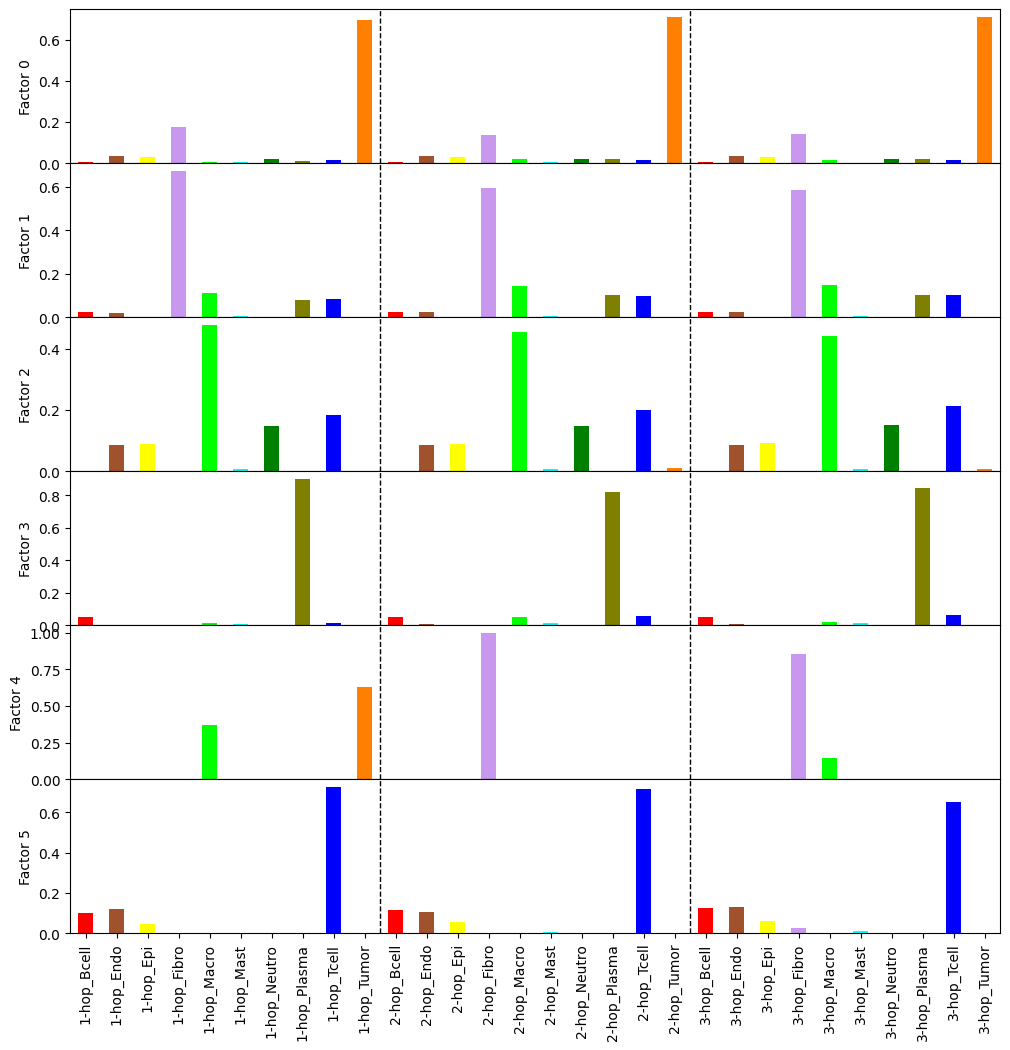

In [5]:
pred_test = np.load(f"{path_name}/remap_loc.npy", allow_pickle = True)
Qdata.obsm['remap'] = pred_test

Qdata = Qdata[~pd.isna(Qdata.obs['Cluster'])].copy()
Qdata.obsm['remap'] = Qdata.obsm['remap'] * 0.18    ## To transform the CosMx location coordinates to um

colors = {"Fibro": "#C798EE", "Macro": "#00FF00", "Tcell": "#0000FF", "Bcell": "#FF0000", "Epi": "#FFFF00", "Tumor": "#FF8000", 
                "Endo": "#A0522D", "Neutro": "#008000", "Mast": "#00FFFF", "DC": "#008080", "Plasma": "#808000"}

remap.nmf_main(Qdata.obs, spatial = Qdata.obsm['remap'], path = path_name, colors = colors, ct_key = 'Cluster', ct_interest = 'Fibro', 
         neighbor_radius = [40, 80, 120], num_factor = 6, random_state=123)